# Spotify x Billboard Five Year Analysis Project: Exploratory Analysis

## Import packages 

In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import fontTools
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

### Set Display Options

#### Set to display all columns (max 500)

In [2]:
pd.set_option('display.max_columns', 500)

#### Disable display window scrolling for notebook

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Import dataframes

### Import All Chart Tracks Table

In [60]:
df1=pd.read_csv("../data/AllChartAlbumTracksRecoded.csv")
df1.head()

,Unnamed: 0,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,album_name,album_id,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_artist,track_artist_id,track_artist_popularity,track_artist_followers,track_artists_genres_consolidate,main_genre,Soundtrack,Rock,Pop,Hip-hop,Edm,Latin,Indie,Christian,Country,Soul,Metal,Jazz,Folk,Funk,Misc,Easy_listening,R&B,Reggae,Show_tunes,No Genre Assigned
0,0,Sand In My Boots,4qeMbs55QlONyrE9YBMA93,42,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[87],False,[2705213],Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,0.354,0.540,3.0,-6.625,1.0,0.587,0.00000,0.112,0.416,69.970,202133.0,4.0,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,87,2705213,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,Wasted On You,4xv9BDq764NSKG3geku9X2,43,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[87],False,[2705213],Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,0.505,0.658,11.0,-5.240,0.0,0.371,0.00136,0.121,0.255,196.002,178520.0,3.0,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,87,2705213,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2,Somebody’s Problem,7cWMnSxmQfKFsIIoRWifbb,36,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[87],False,[2705213],Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,0.658,0.539,5.0,-7.674,1.0,0.665,0.00000,0.123,0.622,136.959,161773.0,4.0,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,87,2705213,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,More Surprised Than Me,6Mn2GFiNNadK0G2ZXRK1fd,36,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[87],False,[2705213],Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,0.488,0.748,6.0,-6.049,1.0,0.244,0.00000,0.124,0.431,84.938,157440.0,4.0,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,87,2705213,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,4,865,3lb2f27695Iuyd82khwU9k,39,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[87],False,[2705213],Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,0.454,0.586,8.0,-5.254,1.0,0.729,0.00000,0.101,0.366,87.891,190680.0,4.0,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,87,2705213,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Import Master Chart Table

In [61]:
df2=pd.read_csv("../data/MasterChartTableRecoded.csv")
df2.head()

,Unnamed: 0,playlist_id,playlist_name,position,album_name,album_id,album_release_date,album_artists,album_artists_ids,album_artists_genres,album_artists_popularity,album_artists_followers,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,album_artist,release_date_datetime,release_year
0,0,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,Dangerous: The Double Album,1qW1C4kDOXnrly22daHbxz,2021-01-08,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],[['contemporary country']],[86],[2705213],More Than My Hometown,65mMCEOu5Ll1DBAfEUmerU,34,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],[['contemporary country']],[86],False,[2705213],0.621,0.868,6,-5.478,1,0.617000,0.0,0.131,0.594,126.010,216573,4,Morgan Wallen,2021-01-08,2021
1,1,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,2,SOUR,6s84u2TUpR3wdUv4NgKA2j,2021-05-21,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],[['pop']],[92],[12088661],drivers license,5wANPM4fQCJwkGd4rN57mH,92,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],[['pop']],[92],True,[12088661],0.561,0.431,10,-8.810,1,0.768000,1.42e-05,0.106,0.137,143.875,242013,4,Olivia Rodrigo,2021-05-21,2021
2,2,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,3,Shoot For The Stars Aim For The Moon,7e7t0MCrNDcJZsPwUKjmOc,2020-07-03,['Pop Smoke'],['0eDvMgVFoNV3TpwtrVCoTj'],[['brooklyn drill']],[89],[8721767],What You Know Bout Love,1tkg4EHVoqnhR6iFEXb60y,85,['Pop Smoke'],['0eDvMgVFoNV3TpwtrVCoTj'],[['brooklyn drill']],[89],True,[8721767],0.709,0.548,10,-8.493,1,0.650000,1.59e-06,0.133,0.543,83.995,160000,4,Pop Smoke,2020-07-03,2020
3,3,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,4,evermore,2Xoteh7uEpea4TohMxjtaq,2020-12-11,['Taylor Swift'],['06HL4z0CvFAxyc27GXpf02'],[['pop']],[100],[47362363],willow,0lx2cLdOt3piJbcaXIV74f,82,['Taylor Swift'],['06HL4z0CvFAxyc27GXpf02'],[['pop']],[100],False,[47362363],0.392,0.574,7,-9.195,1,0.833000,0.00179,0.145,0.529,81.112,214707,4,Taylor Swift,2020-12-11,2020
4,4,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,5,Certified Lover Boy,3SpBlxme9WbeQdI9kx7KAV,2021-09-03,['Drake'],['3TVXtAsR1Inumwj472S9r4'],"[['canadian hip hop', 'canadian pop', 'hip hop...",[98],[59845429],Way 2 Sexy (with Future & Young Thug),0k1WUmIRnG3xU6fvvDVfRG,90,"['Drake', 'Future', 'Young Thug']",['3TVXtAsR1Inumwj472S9r4'],"[['canadian hip hop', 'canadian pop', 'hip hop...",[98],True,[59845429],0.803,0.597,11,-6.035,0,0.000619,4.5e-06,0.323,0.331,136.008,257605,4,Drake,2021-09-03,2021


In [6]:
position_int = list(df2['position'])
df2['chart_position'] = position_int

In [7]:
df3 = df2[["playlist_id", "playlist_name", "chart_position", "album_release_date", "release_year", "release_date_datetime", "album_id", 'album_artist']]

### Join Master Chart and All Track Tables on the Album ID

In [62]:
df4 = pd.merge(df3, df1, on='album_id')
df4.head()

,playlist_id,playlist_name,chart_position,album_release_date,release_year,release_date_datetime,album_id,album_artist,Unnamed: 0,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,album_name,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_artist,track_artist_id,track_artist_popularity,track_artist_followers,track_artists_genres_consolidate,main_genre,Soundtrack,Rock,Pop,Hip-hop,Edm,Latin,Indie,Christian,Country,Soul,Metal,Jazz,Folk,Funk,Misc,Easy_listening,R&B,Reggae,Show_tunes,No Genre Assigned
0,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,2021-01-08,2021,2021-01-08,1qW1C4kDOXnrly22daHbxz,Morgan Wallen,0,Sand In My Boots,4qeMbs55QlONyrE9YBMA93,42,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[87],False,[2705213],Dangerous: The Double Album,0.354,0.540,3.0,-6.625,1.0,0.587,0.00000,0.112,0.416,69.970,202133.0,4.0,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,87,2705213,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,2021-01-08,2021,2021-01-08,1qW1C4kDOXnrly22daHbxz,Morgan Wallen,1,Wasted On You,4xv9BDq764NSKG3geku9X2,43,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[87],False,[2705213],Dangerous: The Double Album,0.505,0.658,11.0,-5.240,0.0,0.371,0.00136,0.121,0.255,196.002,178520.0,3.0,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,87,2705213,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,2021-01-08,2021,2021-01-08,1qW1C4kDOXnrly22daHbxz,Morgan Wallen,2,Somebody’s Problem,7cWMnSxmQfKFsIIoRWifbb,36,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[87],False,[2705213],Dangerous: The Double Album,0.658,0.539,5.0,-7.674,1.0,0.665,0.00000,0.123,0.622,136.959,161773.0,4.0,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,87,2705213,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,2021-01-08,2021,2021-01-08,1qW1C4kDOXnrly22daHbxz,Morgan Wallen,3,More Surprised Than Me,6Mn2GFiNNadK0G2ZXRK1fd,36,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[87],False,[2705213],Dangerous: The Double Album,0.488,0.748,6.0,-6.049,1.0,0.244,0.00000,0.124,0.431,84.938,157440.0,4.0,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,87,2705213,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,1,2021-01-08,2021,2021-01-08,1qW1C4kDOXnrly22daHbxz,Morgan Wallen,4,865,3lb2f27695Iuyd82khwU9k,39,['Morgan Wallen'],['4oUHIQIBe0LHzYfvXNW4QM'],['contemporary country'],[87],False,[2705213],Dangerous: The Double Album,0.454,0.586,8.0,-5.254,1.0,0.729,0.00000,0.101,0.366,87.891,190680.0,4.0,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,87,2705213,['Country'],Country,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [9]:
df4 = df4.drop("Unnamed: 0", axis=1)

In [10]:
df4.to_csv('../data/AllTracksAndChartsJoined.csv')

#### Select five most popular songs for each album on chart

In [11]:
df5 = df4.sort_values('track_popularity', ascending = False).groupby(['playlist_name', 'album_id']).head(5)

In [12]:
df5.to_csv('../data/MostPopularAlbumTracksAllChartsJoined.csv')

## Explorations

### Preliminary Questions

#### Shape of the dataframe:

In [13]:
df4.shape
#(rows, columns)

(16505, 56)

#### Most popular song in dataset:

In [14]:
np.max(df4['track_popularity'])

100

In [15]:
df4.loc[df4['track_popularity'] == 100]

,playlist_id,playlist_name,chart_position,album_release_date,release_year,release_date_datetime,album_id,album_artist,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,album_name,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_artist,track_artist_id,track_artist_popularity,track_artist_followers,track_artists_genres_consolidate,main_genre,Soundtrack,Rock,Pop,Hip-hop,Edm,Latin,Indie,Christian,Country,Soul,Metal,Jazz,Folk,Funk,Misc,Easy_listening,R&B,Reggae,Show_tunes,No Genre Assigned
8219,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,178,1994-11-01,1994,1994-11-01,61ulfFSmmxMhc2wCdmdMkN,Mariah Carey,All I Want for Christmas Is You,0bYg9bo50gSsH3LtXe2SQn,100,['Mariah Carey'],['4iHNK0tOyZPYnBU7nGAgpQ'],"['dance pop', 'pop', 'urban contemporary']",[90],False,[7336768],Merry Christmas,0.336,0.627,7.0,-7.463,1.0,0.164,0.0,0.0708,0.35,150.273,241107.0,4.0,Mariah Carey,4iHNK0tOyZPYnBU7nGAgpQ,90,7336768,"['Pop', 'Pop', 'R&B']",Pop,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8229,1EEazdcjH0keT4sttGvH8c,Billboard 200 Top Albums 2020,168,1994-11-01,1994,1994-11-01,61ulfFSmmxMhc2wCdmdMkN,Mariah Carey,All I Want for Christmas Is You,0bYg9bo50gSsH3LtXe2SQn,100,['Mariah Carey'],['4iHNK0tOyZPYnBU7nGAgpQ'],"['dance pop', 'pop', 'urban contemporary']",[90],False,[7336768],Merry Christmas,0.336,0.627,7.0,-7.463,1.0,0.164,0.0,0.0708,0.35,150.273,241107.0,4.0,Mariah Carey,4iHNK0tOyZPYnBU7nGAgpQ,90,7336768,"['Pop', 'Pop', 'R&B']",Pop,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8239,0n3V7u9sMRV7sCDMhWxDtL,Billboard 200 Top Albums 2019,191,1994-11-01,1994,1994-11-01,61ulfFSmmxMhc2wCdmdMkN,Mariah Carey,All I Want for Christmas Is You,0bYg9bo50gSsH3LtXe2SQn,100,['Mariah Carey'],['4iHNK0tOyZPYnBU7nGAgpQ'],"['dance pop', 'pop', 'urban contemporary']",[90],False,[7336768],Merry Christmas,0.336,0.627,7.0,-7.463,1.0,0.164,0.0,0.0708,0.35,150.273,241107.0,4.0,Mariah Carey,4iHNK0tOyZPYnBU7nGAgpQ,90,7336768,"['Pop', 'Pop', 'R&B']",Pop,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [16]:
print(f"Most popular song: {set(df4[df4['track_popularity'] == 100]['track_name'].tolist())}" f" by {set(df4[df4['track_popularity'] == 100]['track_artist'].tolist())}\n")

Most popular song: {'All I Want for Christmas Is You'} by {'Mariah Carey'}



#### Scatter plot of track popularity compared to valence

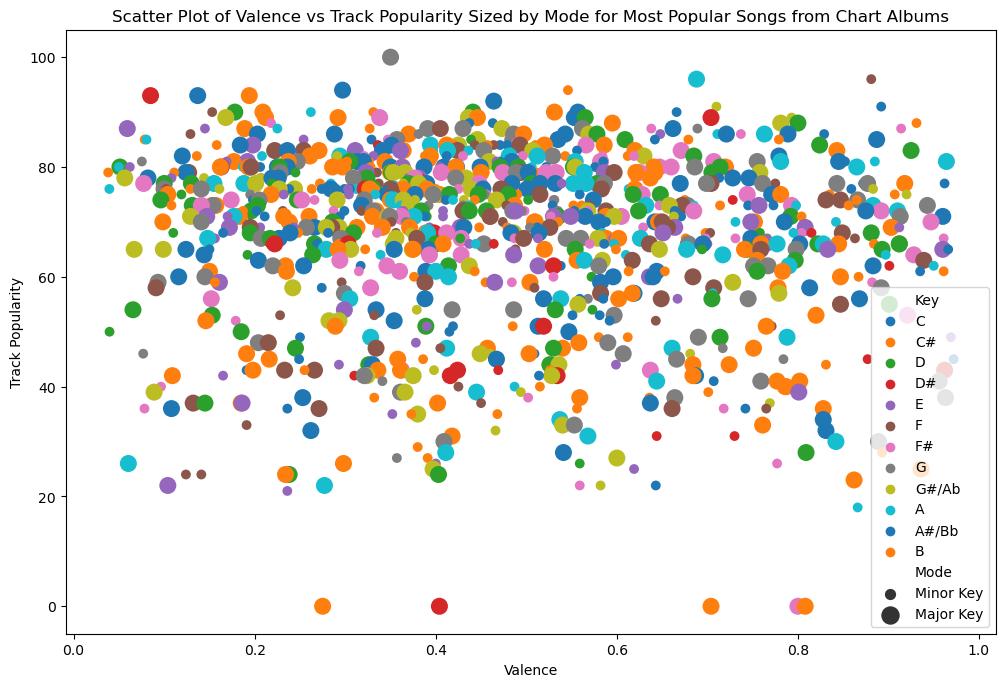

In [17]:
sns.scatterplot(x="valence", y="track_popularity",
                hue="key",
                size="mode",
                palette="tab10",
                sizes=(150, 50), linewidth=0,
                data= df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2021'])
plt.title('Scatter Plot of Valence vs Track Popularity Sized by Mode for Most Popular Songs from Chart Albums')
plt.xlabel('Valence')
plt.ylabel('Track Popularity')
vpm_plot_key=plt.legend()
vpm_plot_key.get_texts()[0].set_text('Key')
vpm_plot_key.get_texts()[1].set_text('C')
vpm_plot_key.get_texts()[2].set_text('C#')
vpm_plot_key.get_texts()[3].set_text('D')
vpm_plot_key.get_texts()[4].set_text('D#')
vpm_plot_key.get_texts()[5].set_text('E')
vpm_plot_key.get_texts()[6].set_text('F')
vpm_plot_key.get_texts()[7].set_text('F#')
vpm_plot_key.get_texts()[8].set_text('G')
vpm_plot_key.get_texts()[9].set_text('G#/Ab')
vpm_plot_key.get_texts()[10].set_text('A')
vpm_plot_key.get_texts()[11].set_text('A#/Bb')
vpm_plot_key.get_texts()[12].set_text('B')
vpm_plot_key.get_texts()[13].set_text('Mode')
vpm_plot_key.get_texts()[14].set_text('Minor Key')
vpm_plot_key.get_texts()[15].set_text('Major Key')
plt.savefig('../viz/pyplots/ValencePopularityModeScatterPlot.png')

#### Average loudness for all chart years together: 

In [18]:
print(f"Average loudness for all years: {np.mean(df4['loudness'])} dB\n")

Average loudness for all years: -7.482124091129442 dB



#### Average loudness for each chart year: 

In [19]:
print(f"Average loudness in 2017: {np.mean(df4[df4['playlist_name'] == 'Billboard 200 Top Albums 2017']['loudness'])} dB")
print(f"Average loudness in 2018: {np.mean(df4[df4['playlist_name'] == 'Billboard 200 Top Albums 2018']['loudness'])} dB")
print(f"Average loudness in 2019: {np.mean(df4[df4['playlist_name'] == 'Billboard 200 Top Albums 2019']['loudness'])} dB")
print(f"Average loudness in 2020: {np.mean(df4[df4['playlist_name'] == 'Billboard 200 Top Albums 2020']['loudness'])} dB")
print(f"Average loudness in 2021: {np.mean(df4[df4['playlist_name'] == 'Billboard 200 Top Albums 2021']['loudness'])} dB")

Average loudness in 2017: -7.362742773627801 dB
Average loudness in 2018: -7.208551659361308 dB
Average loudness in 2019: -7.458067571555021 dB
Average loudness in 2020: -7.681900204858057 dB
Average loudness in 2021: -7.669060729927005 dB


In [20]:
loudness_frame = df4[['track_id', 'playlist_name', 'main_genre', 'loudness', 'energy']]
average_loudness = list(loudness_frame.groupby('playlist_name')['loudness'].mean())
average_loudness

[-7.362742773627801,
 -7.208551659361308,
 -7.458067571555021,
 -7.681900204858057,
 -7.669060729927005]

#### Chart of change in average loudness over time

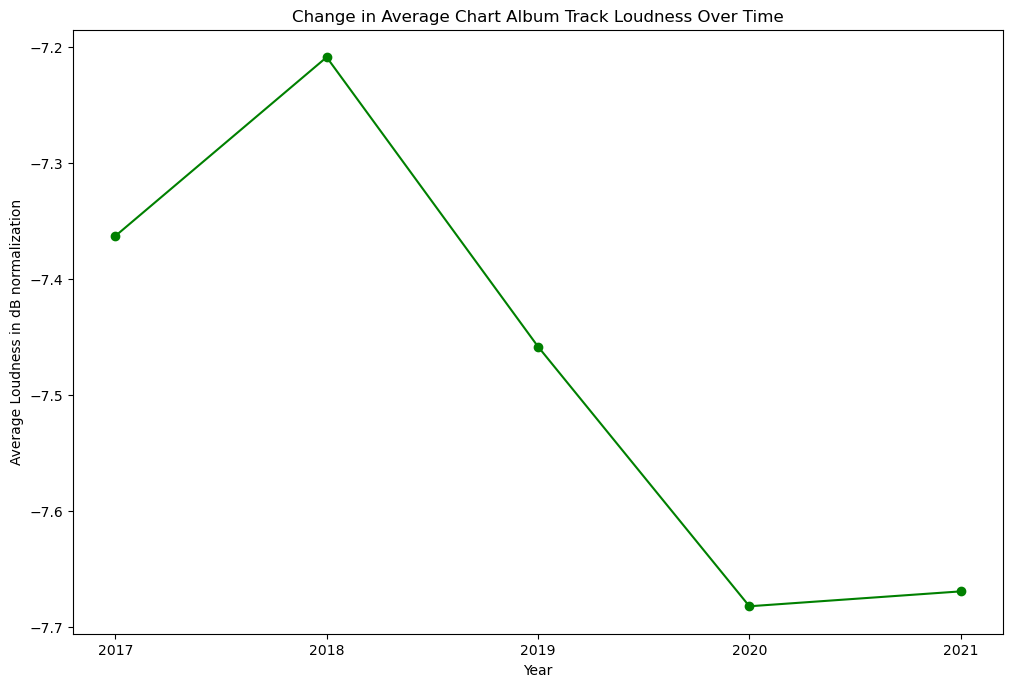

<Figure size 1200x800 with 0 Axes>

In [21]:
years = [2017, 2018, 2019, 2020, 2021]
plt.plot(years, average_loudness, color='green', marker='o', linestyle='solid')
plt.title("Change in Average Chart Album Track Loudness Over Time")
plt.xlabel("Year")
plt.ylabel("Average Loudness in dB normalization")
plt.xticks(np.arange(min(years), max(years)+1, 1.0))
plt.show()
plt.savefig('../viz/pyplots/LoudnessMeansOverTimeLineChart.png')

#### Error bar of average loudness by genre

In [22]:
# create new table
all_genre_features_table = df4[['track_name', 'track_id', 'main_genre', 'loudness', 'valence']]
# grouping loudness by genre
genre_loudness = all_genre_features_table.groupby('main_genre')['loudness'].aggregate(['min', np.mean, 'max'])
# merge
genre_loudness_error = pd.merge(all_genre_features_table, genre_loudness, how='left', left_on='main_genre', right_on = 'main_genre', copy=False).fillna(0)

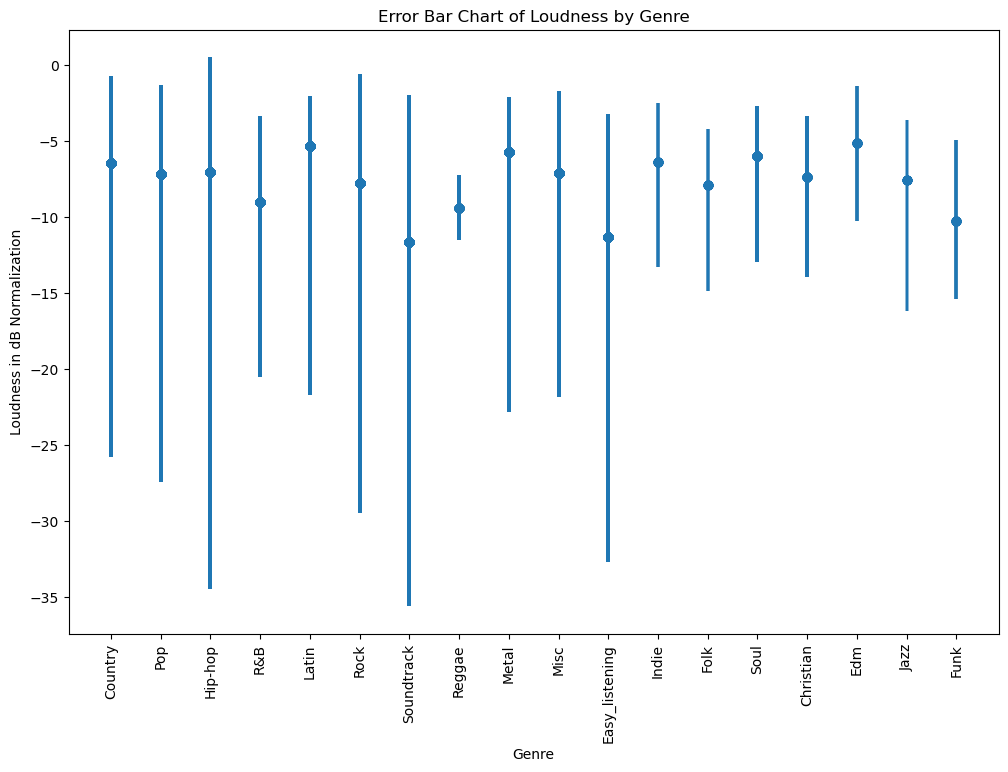

<Figure size 1200x800 with 0 Axes>

In [23]:
# Plot
plt.errorbar(genre_loudness_error["main_genre"],genre_loudness_error["mean"], [genre_loudness_error["mean"] - genre_loudness_error['min'],genre_loudness_error['max']-genre_loudness_error["mean"]], linestyle='None',marker='o')
plt.xticks(rotation='vertical')
plt.title('Error Bar Chart of Loudness by Genre')
plt.xlabel('Genre')
plt.ylabel('Loudness in dB Normalization')
plt.show()
plt.savefig('../viz/pyplots/LoudnessbyGenreErrorChart.png')

#### Average valence for most popular album tracks all chart years together: 

In [24]:
print(f"Average valence for all years: {np.mean(df5['valence'])} dB\n")

Average valence for all years: 0.46879270308405546 dB



#### Error bar of average valence by genre

In [25]:
# create new table
all_genre_features_table = df4[['track_name', 'track_id', 'main_genre', 'loudness', 'valence']]
# grouping loudness by genre
genre_valence = all_genre_features_table.groupby('main_genre')['valence'].aggregate(['min', np.mean, 'max'])
# merge
genre_valence_error = pd.merge(all_genre_features_table, genre_valence, how='left', left_on='main_genre', right_on = 'main_genre', copy=False).fillna(0)

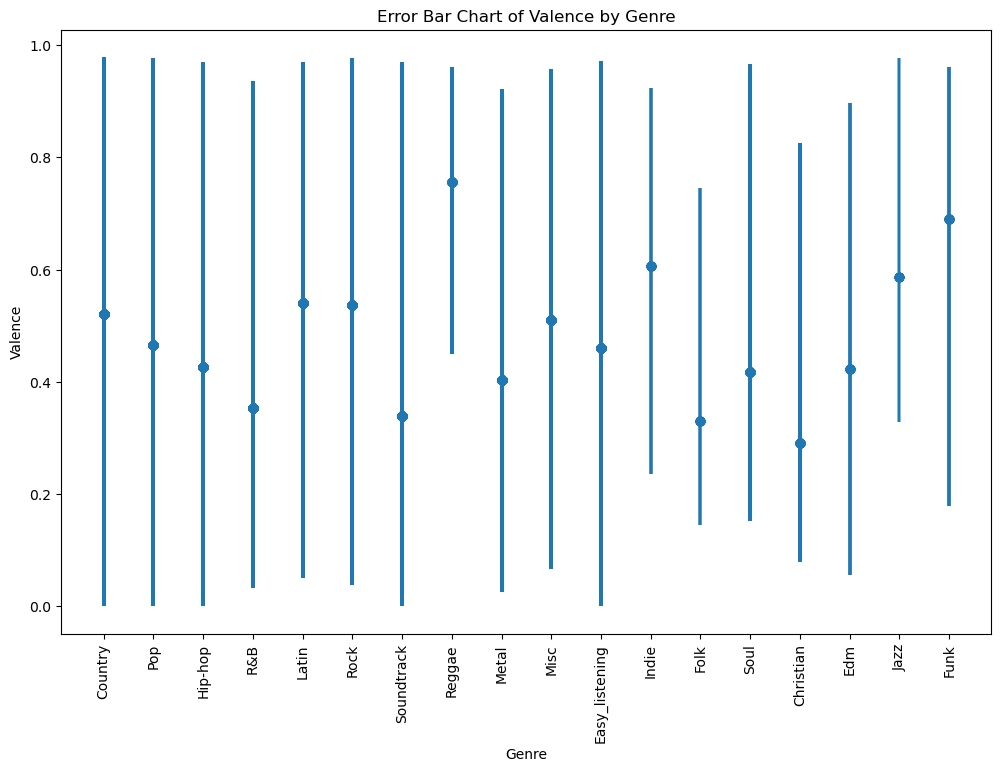

<Figure size 1200x800 with 0 Axes>

In [26]:
# Plot
plt.errorbar(genre_valence_error["main_genre"],genre_valence_error["mean"], [genre_valence_error["mean"] - genre_valence_error['min'],genre_valence_error['max'] - genre_valence_error["mean"]], linestyle='None',marker='o')
plt.xticks(rotation='vertical')
plt.title('Error Bar Chart of Valence by Genre')
plt.xlabel('Genre')
plt.ylabel('Valence')
plt.show()
plt.savefig('../viz/pyplots/ValencebyGenreErrorChart.png')

#### Count plot for songs in each major and minor key

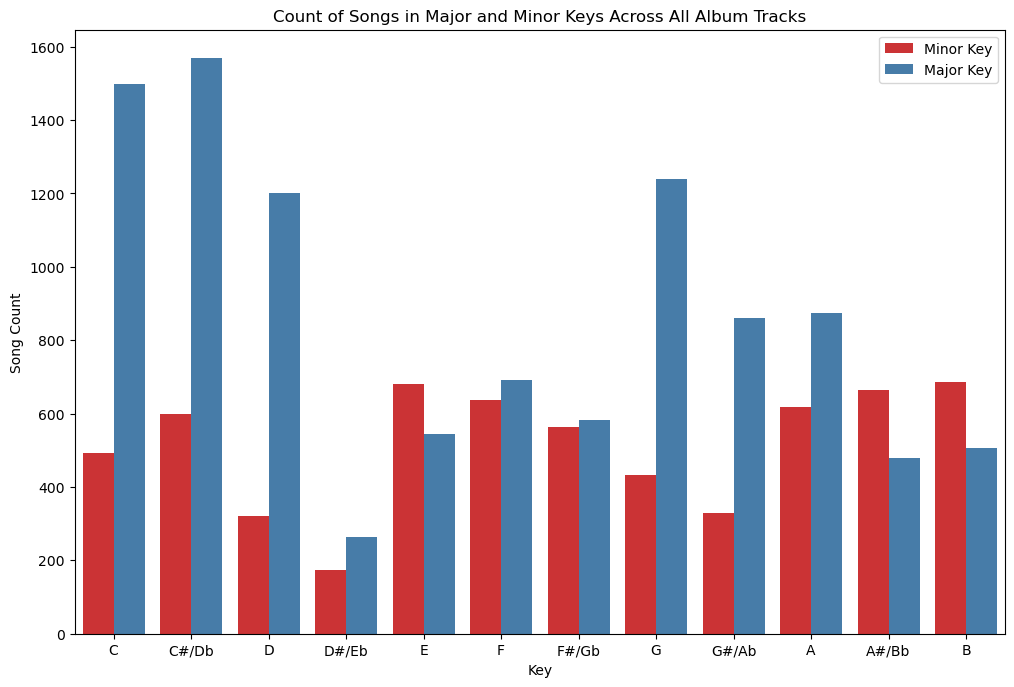

In [27]:
key_plot = sns.countplot(data=df4, x='key', hue='mode', palette = 'Set1')
plt.xlabel('Key')
plt.ylabel('Song Count')
plt.title('Count of Songs in Major and Minor Keys Across All Album Tracks')
key_plot.set_xticklabels(['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G', 'G#/Ab', 'A', 'A#/Bb', 'B'])
plot_modes=plt.legend()
plot_modes.get_texts()[0].set_text('Minor Key')
plot_modes.get_texts()[1].set_text('Major Key')
plt.savefig('../viz/pyplots/KeyCountPlot.png')

#### Number of tracks with explicit lyrics

In [28]:
df4['track_explicit'].value_counts()

False    10364
True      6141
Name: track_explicit, dtype: int64

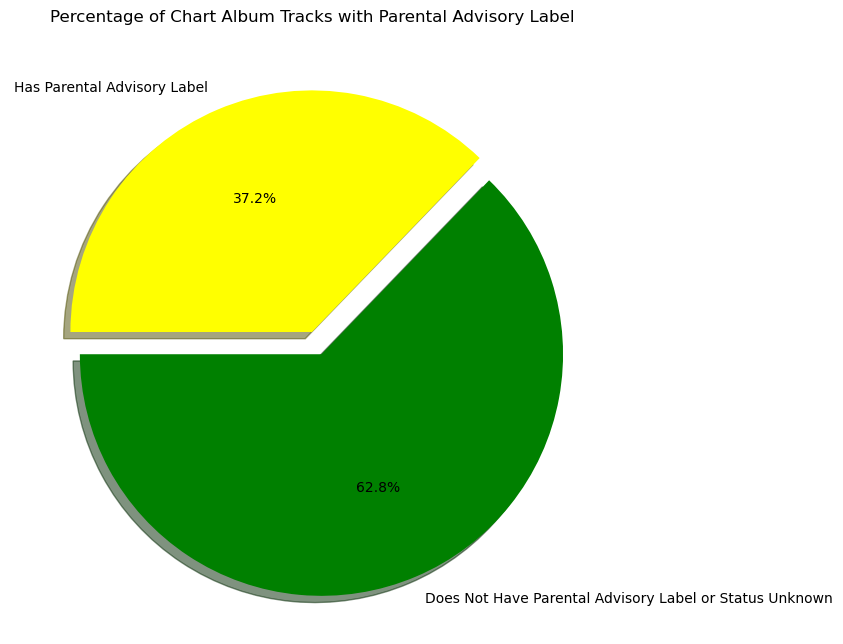

In [29]:
plt.pie(df4['track_explicit'].value_counts(), 
        explode=(0.1, 0), 
        colors=['green', 'yellow'], 
        autopct='%1.1f%%',
        shadow=True,
        startangle=180, labels = ['Does Not Have Parental Advisory Label or Status Unknown', 'Has Parental Advisory Label']);
plt.title('Percentage of Chart Album Tracks with Parental Advisory Label')
plt.savefig('../viz/pyplots/ExplicitPieChart.png')

#### Explicit Lyrics by Genre

In [30]:
# Slice dataset
exp_track = df4[['main_genre', 'track_explicit']]
#Dummy code the explicit column
exp_dummy = pd.get_dummies(exp_track, prefix='exp', columns=['track_explicit'])
# Create grouped df
exp_dummy_grouped = exp_dummy.groupby(
     ['main_genre']
 ).agg(
     not_exp = ('exp_False','sum'),
     exp = ('exp_True','sum'),
 ).reset_index()

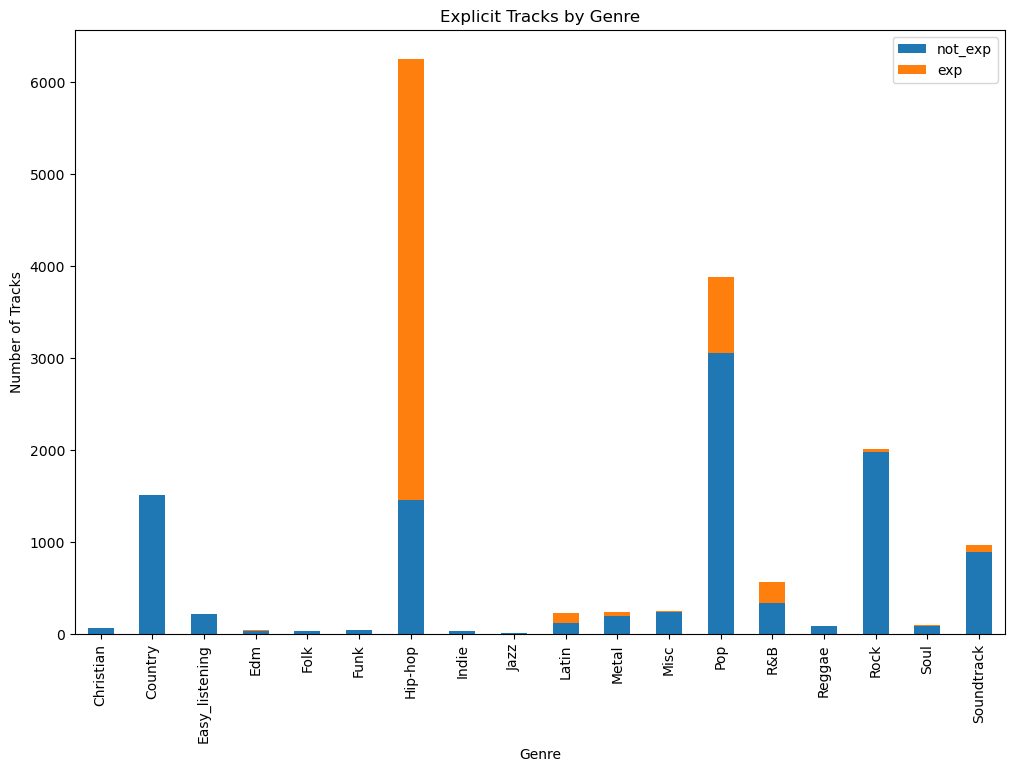

In [31]:
# Create stacked bar chart
labels = list(exp_dummy_grouped['main_genre'])
ax = exp_dummy_grouped.plot(kind='bar', stacked=True)
ax.set(xticklabels = (labels))
plt.title("Explicit Tracks by Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Tracks")
plt.savefig('../viz/pyplots/ExpGenreStackedBarChart.png')

#### Stacked to 100% (filled) bar chart 

In [32]:
plotdata = exp_dummy_grouped.set_index('main_genre')

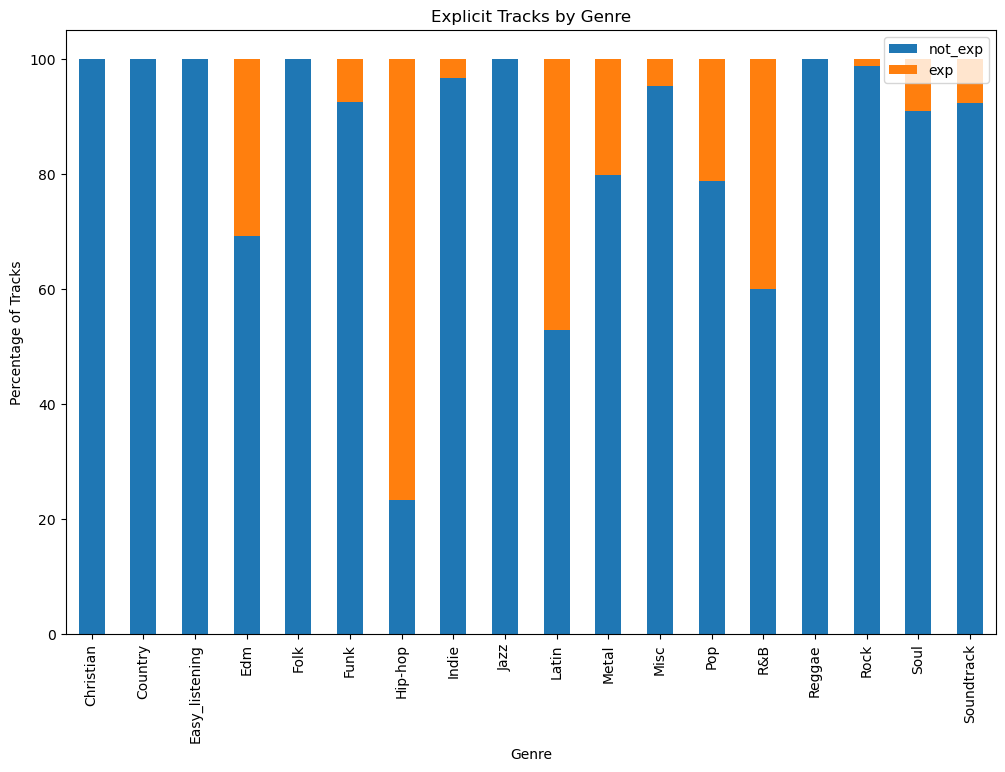

In [33]:
stacked_data = plotdata.apply(lambda x: x*100/sum(x), axis=1)
labels = list(exp_dummy_grouped['main_genre'])
ax = stacked_data.plot(kind='bar', stacked=True)
ax.set(xticklabels = (labels))
plt.title("Explicit Tracks by Genre")
plt.xlabel("Genre")
plt.ylabel("Percentage of Tracks")
plt.savefig('../viz/pyplots/ExpGenreFilledBarChart.png')

#### Explicit Lyrics by Year

In [34]:
# Slice dataset
exp_year = df4[['playlist_name', 'track_explicit']]
#Dummy code the explicit column
exp_year_dummy = pd.get_dummies(exp_year, prefix='exp', columns=['track_explicit'])
# Create grouped df
exp_year_dummy_grouped = exp_year_dummy.groupby(
     ['playlist_name']
 ).agg(
     not_exp = ('exp_False','sum'),
     exp = ('exp_True','sum'),
 ).reset_index()
exp_year_dummy_grouped

,playlist_name,not_exp,exp
0,Billboard 200 Top Albums 2017,2060.0,1019.0
1,Billboard 200 Top Albums 2018,1983.0,1211.0
2,Billboard 200 Top Albums 2019,2067.0,1323.0
3,Billboard 200 Top Albums 2020,2097.0,1320.0
4,Billboard 200 Top Albums 2021,2157.0,1268.0


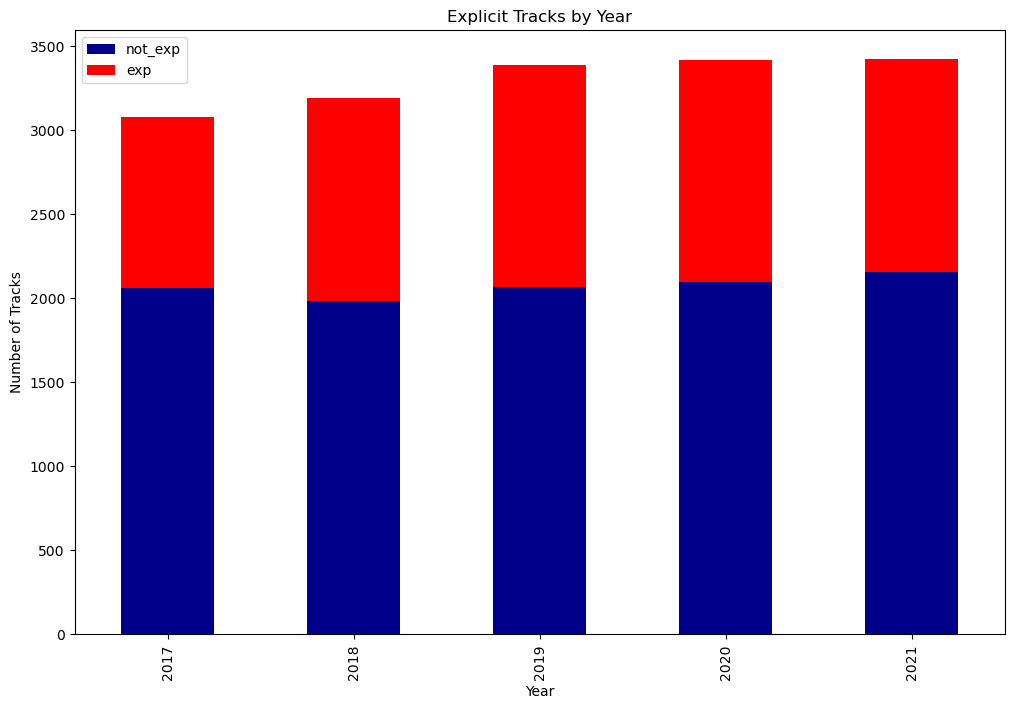

In [35]:
# Create stacked bar chart
labels = list(['2017', '2018', '2019', '2020', '2021'])
ax = exp_year_dummy_grouped.plot(kind='bar', stacked=True, color=['darkblue', 'red'])
ax.set(xticklabels = (labels))
plt.title("Explicit Tracks by Year")
plt.xlabel("Year")
plt.ylabel("Number of Tracks")
plt.savefig('../viz/pyplots/ExpYearStackedBarChart.png')

#### Stacked to 100% (filled) bar chart 

In [36]:
plotdata = exp_year_dummy_grouped.set_index('playlist_name')
plotdata.head()

,not_exp,exp
playlist_name,,
Billboard 200 Top Albums 2017,2060.0,1019.0
Billboard 200 Top Albums 2018,1983.0,1211.0
Billboard 200 Top Albums 2019,2067.0,1323.0
Billboard 200 Top Albums 2020,2097.0,1320.0
Billboard 200 Top Albums 2021,2157.0,1268.0


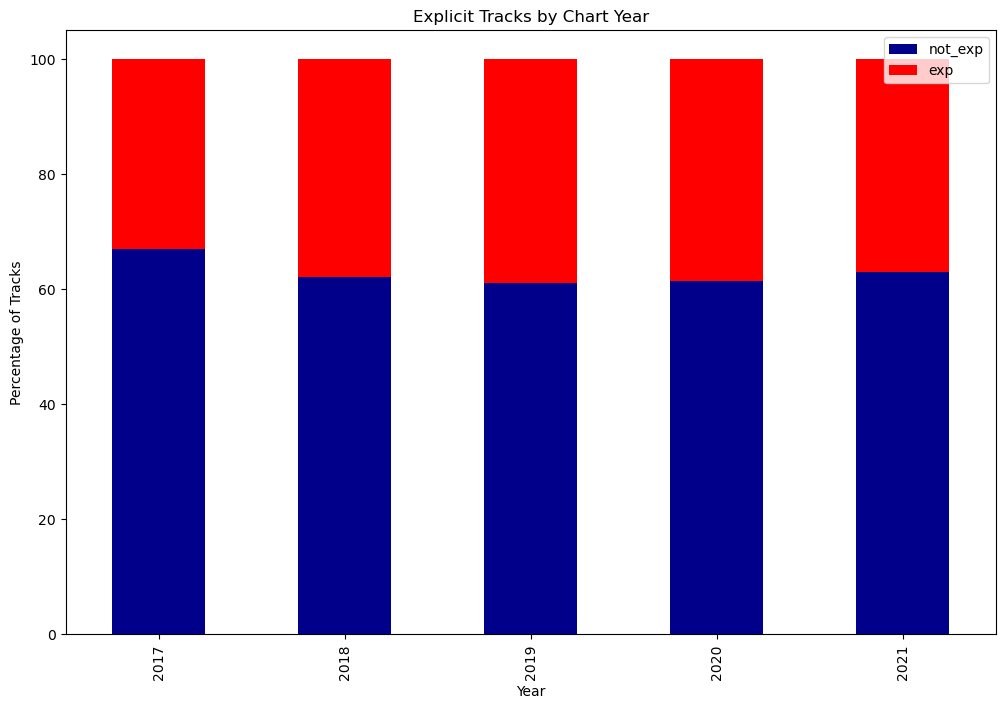

In [37]:
stacked_data = plotdata.apply(lambda x: x*100/sum(x), axis=1)
labels = list(['2017', '2018', '2019', '2020', '2021'])
ax = stacked_data.plot(kind='bar', stacked=True, color=['darkblue', 'red'])
ax.set(xticklabels = (labels))
plt.title("Explicit Tracks by Chart Year")
plt.xlabel("Year")
plt.ylabel("Percentage of Tracks")
plt.savefig('../viz/pyplots/ExpYearFilledBarChart.png')

#### Average valence for most popular album songs for each chart year: 

In [38]:
print(f"Average valence in 2017: {np.mean(df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2017']['valence'])}")
print(f"Average valence in 2018: {np.mean(df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2018']['valence'])}")
print(f"Average valence in 2019: {np.mean(df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2019']['valence'])}")
print(f"Average valence in 2020: {np.mean(df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2020']['valence'])}")
print(f"Average valence in 2021: {np.mean(df5[df5['playlist_name'] == 'Billboard 200 Top Albums 2021']['valence'])}")

Average valence in 2017: 0.4652556701030933
Average valence in 2018: 0.46066633165829146
Average valence in 2019: 0.46098544176706735
Average valence in 2020: 0.4796822999999993
Average valence in 2021: 0.4771957999999995


#### Mean values of each audio feature

In [39]:
df4[['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']].mean()

danceability        0.624576
energy              0.601458
acousticness        0.262261
instrumentalness    0.029719
liveness            0.189858
valence             0.454809
dtype: float64

#### Bar plot of audio feature means of most popular tracks per album

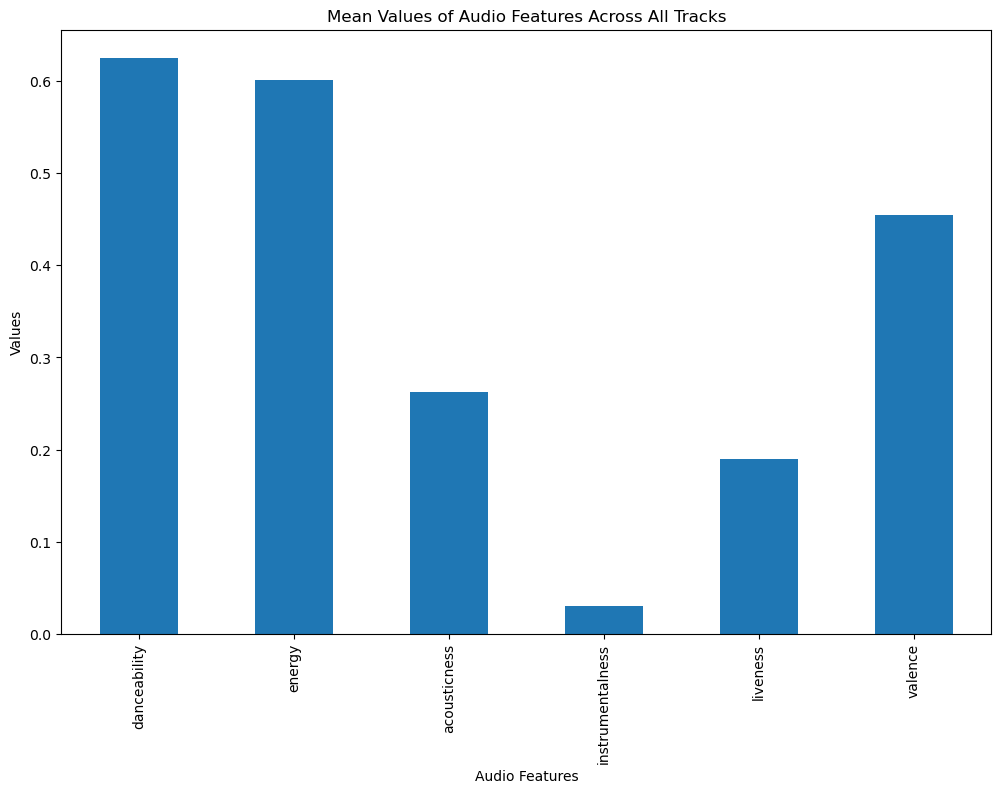

In [40]:
feature_bars = df4[['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']]
feature_bars.mean().plot.bar()
plt.title('Mean Values of Audio Features Across All Tracks')
plt.xlabel('Audio Features')
plt.ylabel('Values')
plt.savefig('../viz/pyplots/MeanAudioFeaturesBarPlot.png')

#### Histograms of audio features

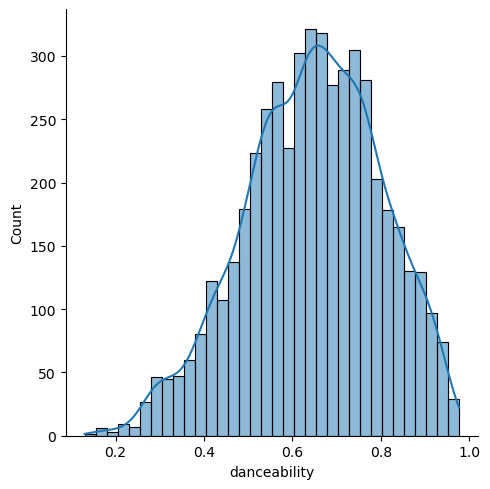

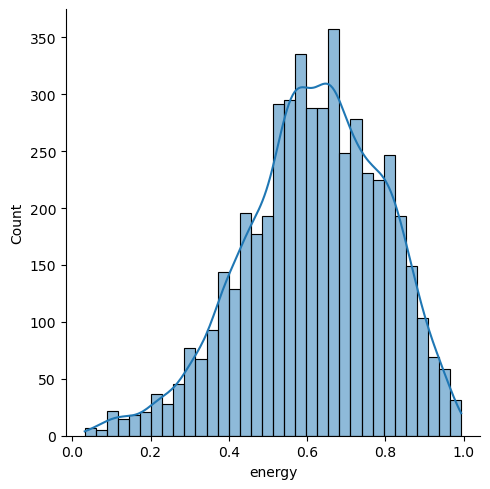

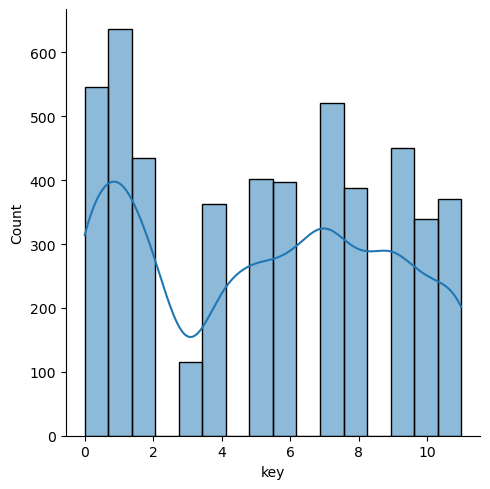

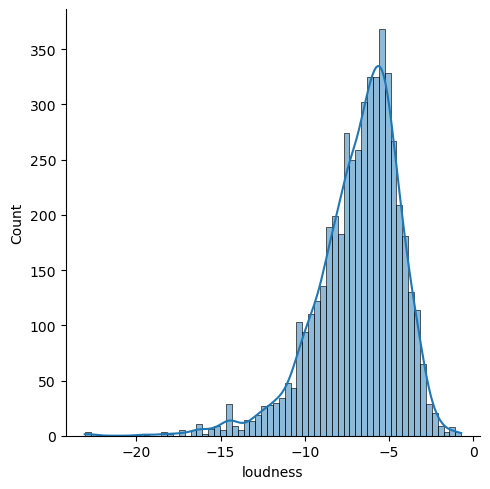

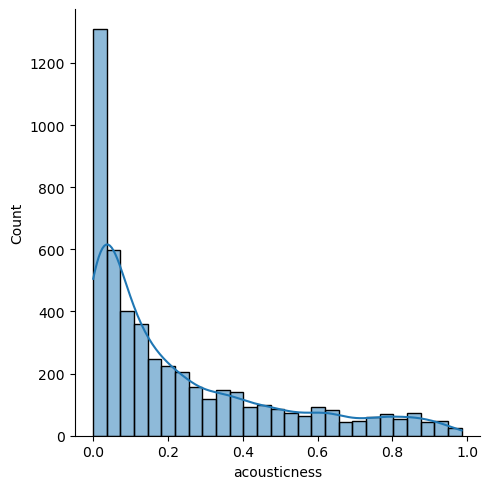

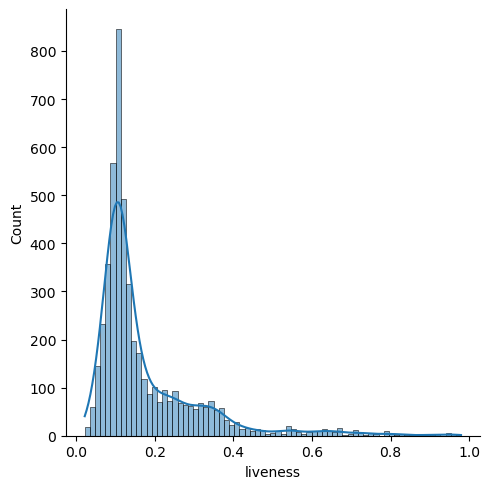

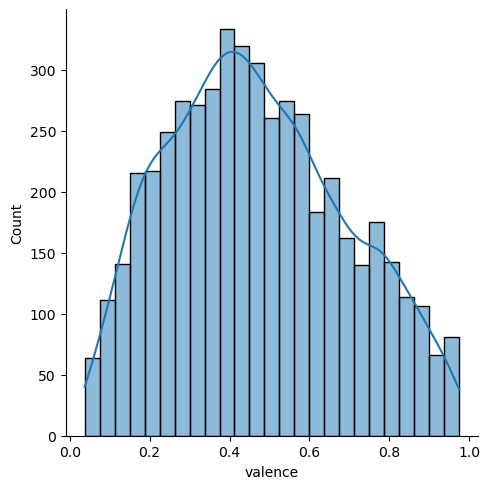

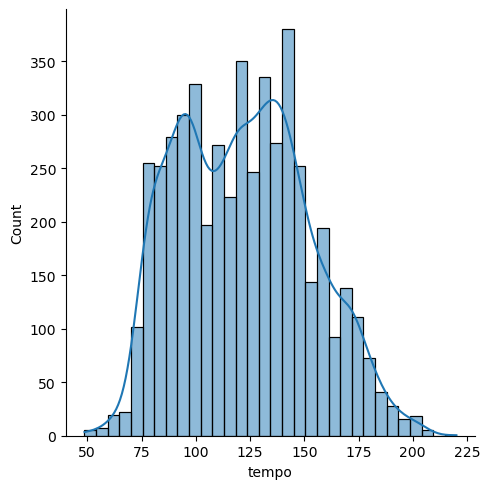

In [41]:
features = ['danceability', 'energy', 'key', 'loudness', 'acousticness', 'liveness', 'valence','tempo']
for col in features:
  sns.displot(df5, x=col, kde=True)
  plt.show()

#### Correlation Heatmap of Features

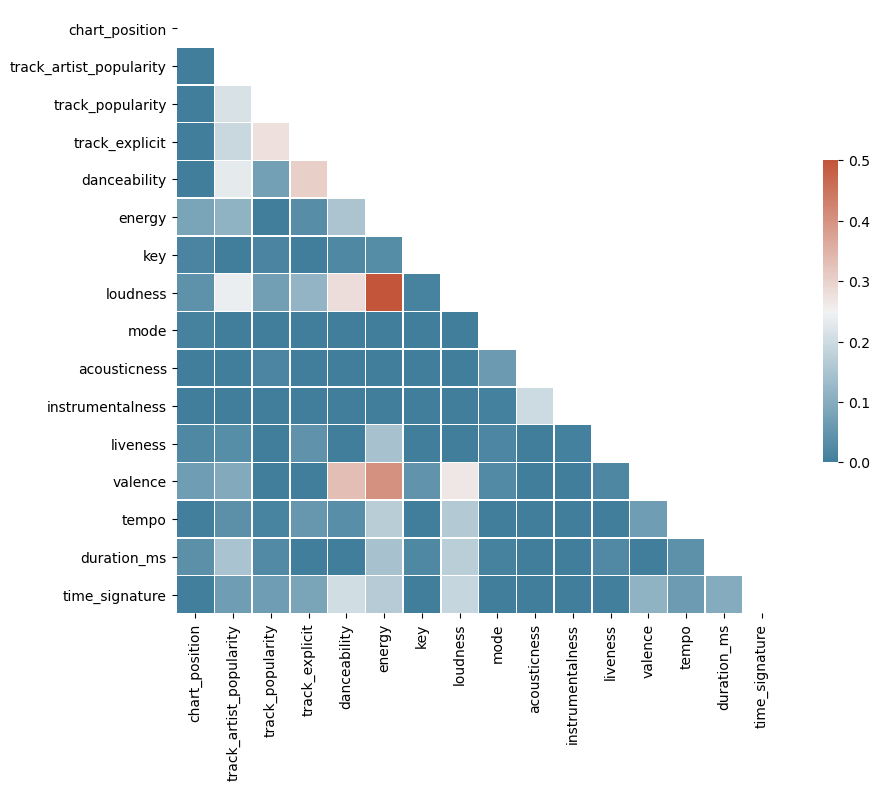

In [63]:
# Dataframe with audio features
track_feature_corr = df4[['playlist_name', 'chart_position', 'track_artist_popularity', 'track_popularity', 'track_explicit', 'danceability', 'energy', 'key','loudness', 'mode', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

# Generate a mask for the upper part of the chart
mask = np.triu(np.ones_like(track_feature_corr.corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Can add mask=mask in sns.heatmap to mask top triangle of plot. Removed to view entire plot.
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(track_feature_corr.corr(), cmap=cmap, vmin=0, mask=mask, vmax=.5, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('../viz/pyplots/CorrHeatMapAllTracks.png')

#### Average song length

In [43]:
print(f"Average song duration in minutes for all years: {int(np.mean(df4['duration_ms']) // 60000)}:" f"{round(np.mean(df4['duration_ms'] / 10000) % 60)} \n")

Average song duration in minutes for all years: 3:21 



In [44]:
print(f"Average song duration in minutes for all years: {int(np.mean(df4['duration_ms']) // 60000)}:" f"{round(np.mean(df4['duration_ms'] / 10000) % 60)} \n")

Average song duration in minutes for all years: 3:21 



#### Longest song

In [45]:
print(f"Longest song in minutes: {df4.iloc[df4['duration_ms'].idxmax()]['track_name']} by "
        f"{df4.iloc[df4['duration_ms'].idxmax()]['track_artist']}, length = "
        f"{int(df4['duration_ms'].max() // 60000)}:" f"{round((df4['duration_ms'].max() / 10000) % 60)}\n")

Longest song in minutes: Like I Never Left (feat. Diddy & Ludacris, feat. Pharrell, Pusha T & Casino) by Future, length = 25:35



#### Artist that has the most appearances on charts across the entire dataset year range

In [46]:
df_freq_art = df2.dropna(subset=['album_artist'])
print(f"Most frequently appearing album artist: {df_freq_art['album_artist'].value_counts().idxmax()}" f" appears {df_freq_art['album_artist'].value_counts().max()} times.\n")

Most frequently appearing album artist: Drake appears 31 times.



#### Number of chart appearances by particular artists:

In [47]:
print("Number of chart appearances of albums by Taylor Swift: " + str(df2['album_artist'].str.contains("Taylor Swift").sum()))
print("Number of chart appearances of albums by Queen: " + str(df2['album_artist'].str.contains("Queen").sum()))
print("Number of chart appearances of albums by Elton John: " + str(df2['album_artist'].str.contains("Elton John").sum()))

Number of chart appearances of albums by Taylor Swift: 15
Number of chart appearances of albums by Queen: 7
Number of chart appearances of albums by Elton John: 4


#### Create word cloud viz of artist chart appearance frequency

Create df of artist frequencies

In [48]:
album_artist_chart_count = df2['album_artist'].value_counts()
album_artist_chart_count = album_artist_chart_count.reset_index()
album_artist_chart_count.columns = ['artist_name', 'artist_chart_frequency'] # change column names

Convert df to dict

In [49]:
artist_freq = dict(zip(album_artist_chart_count['artist_name'].tolist(), album_artist_chart_count['artist_chart_frequency'].tolist()))

Plot word cloud

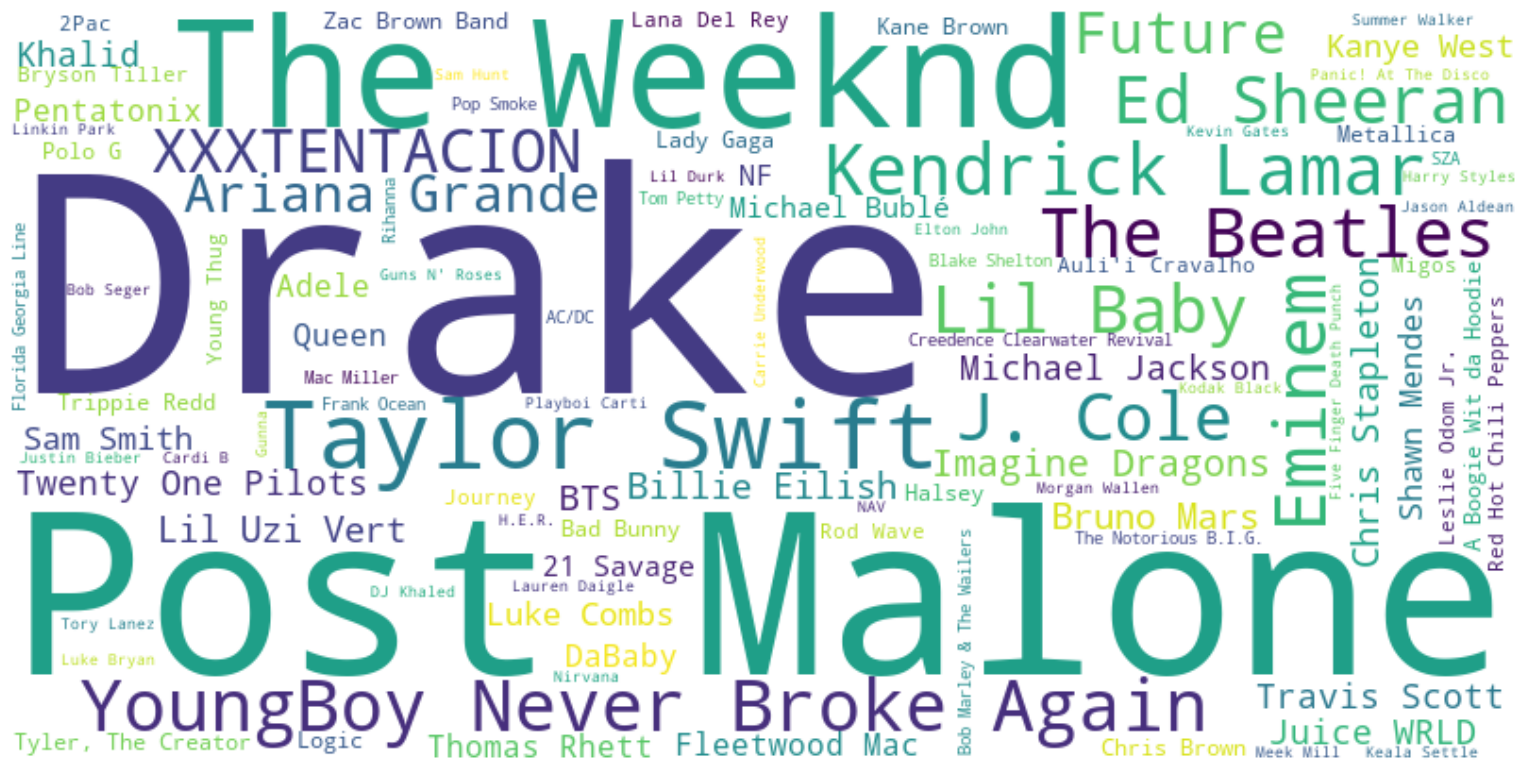

In [50]:
wc_white = WordCloud(background_color='white',width=800, height=400, max_words=100).generate_from_frequencies(artist_freq)
plt.figure(figsize=(20, 10))
plt.imshow(wc_white, interpolation='bilinear')
plt.axis('off')
plt.show()
# Plot visualizations must be saved manually as png, but can be exported to svg with the following:
# wordcloud_svg = wc_white.to_svg(embed_font=True)
# f = open("../viz/pyplots/ArtistChartAppearanceWordCloudWhite.svg","w+")
# f.write(wordcloud_svg )
# f.close()

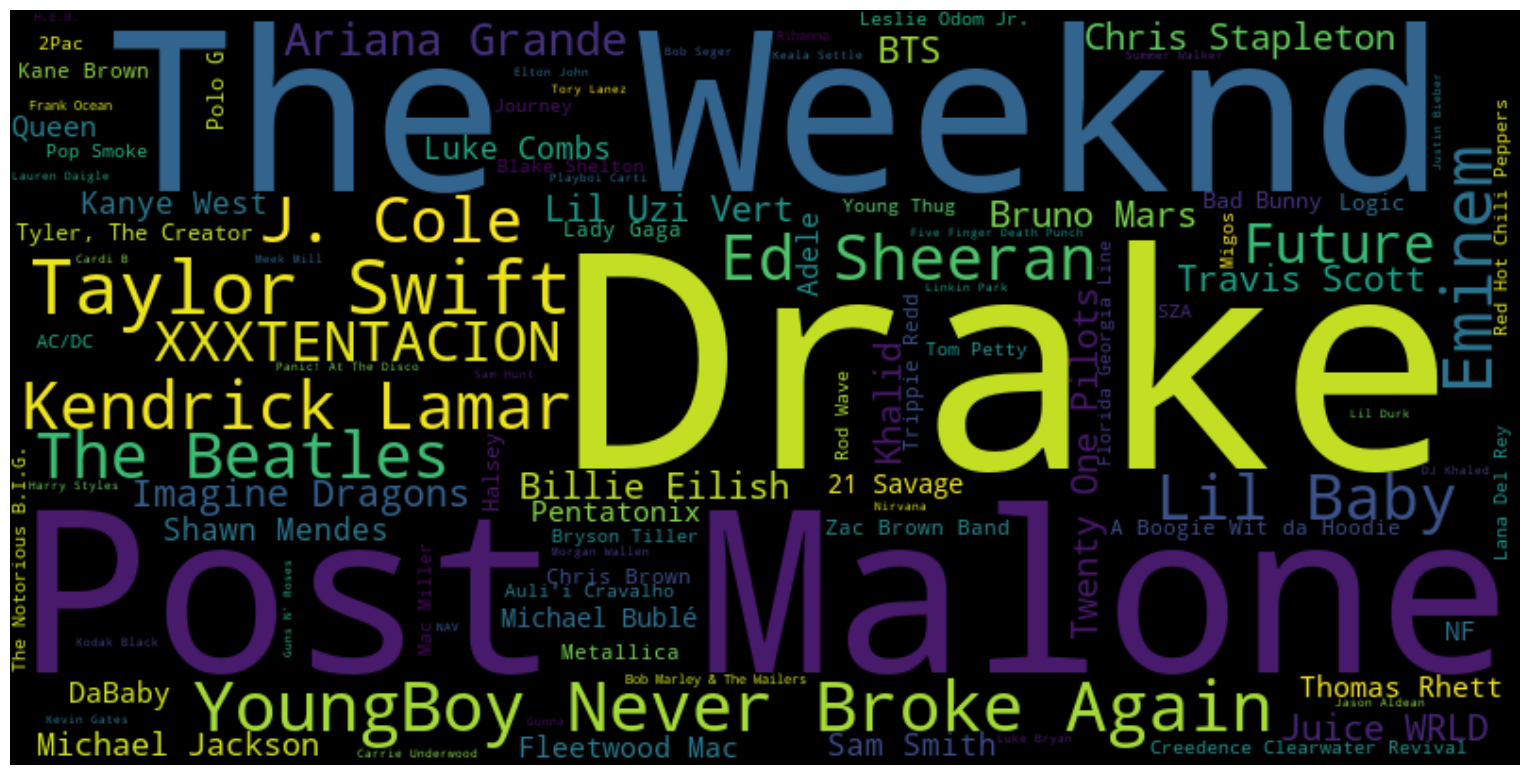

In [51]:
wc_black = WordCloud(background_color='black',width=800, height=400, max_words=100).generate_from_frequencies(artist_freq)
plt.figure(figsize=(20, 10))
plt.imshow(wc_black, interpolation='bilinear')
plt.axis('off')
plt.show()
# Plot visualizations must be saved manually as png, but can be exported to svg with the following:
# wordcloud_svg = wc_black.to_svg(embed_font=True)
# f = open("../viz/pyplots/ArtistChartAppearanceWordCloudBlack.svg","w+")
# f.write(wordcloud_svg )
# f.close()

#### Queen songs appearances on all charts

In [52]:
df2.loc[df2['album_artist'] == "Queen"]

,Unnamed: 0,playlist_id,playlist_name,position,album_name,album_id,album_release_date,album_artists,album_artists_ids,album_artists_genres,album_artists_popularity,album_artists_followers,track_name,track_id,track_popularity,track_artists,track_artists_ids,track_artists_genres,track_artists_popularity,track_explicit,track_artists_followers,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,album_artist,release_date_datetime,release_year,chart_position
22,22,3avCwQPH6DkhMTRsizon7N,Billboard 200 Top Albums 2021,23,Greatest Hits,6a8nlV9V8kPUbTTCJNVSsh,2014,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[89],[38849077],Bohemian Rhapsody - Remastered 2011,6ljkRMigoNtu0x1mlTEsKc,36,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[89],False,[38849077],0.393,0.398,0,-9.973,0,0.256,0.0,0.195,0.2360,143.353,355467,4,Queen,2014-01-01,2014,23
224,224,1EEazdcjH0keT4sttGvH8c,Billboard 200 Top Albums 2020,25,Greatest Hits,6a8nlV9V8kPUbTTCJNVSsh,2014,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[89],[38849077],Bohemian Rhapsody - Remastered 2011,6ljkRMigoNtu0x1mlTEsKc,36,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[89],False,[38849077],0.393,0.398,0,-9.973,0,0.256,0.0,0.195,0.2360,143.353,355467,4,Queen,2014-01-01,2014,25
411,411,0n3V7u9sMRV7sCDMhWxDtL,Billboard 200 Top Albums 2019,12,Bohemian Rhapsody (The Original Soundtrack),3BHe7LbW5yRjyqXNJ3A6mW,2018-10-19,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[89],[38849077],The Show Must Go On - 2011 Remaster,0LCWyLFPXIeg1CIC1NS712,41,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[89],False,[38849077],0.425,0.675,11,-6.790,0,0.433,4.51e-06,0.112,0.0671,84.156,271612,4,Queen,2018-10-19,2018,12
426,426,0n3V7u9sMRV7sCDMhWxDtL,Billboard 200 Top Albums 2019,27,Greatest Hits,6a8nlV9V8kPUbTTCJNVSsh,2014,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[89],[38849077],Bohemian Rhapsody - Remastered 2011,6ljkRMigoNtu0x1mlTEsKc,36,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[89],False,[38849077],0.393,0.398,0,-9.973,0,0.256,0.0,0.195,0.2360,143.353,355467,4,Queen,2014-01-01,2014,27
479,479,0n3V7u9sMRV7sCDMhWxDtL,Billboard 200 Top Albums 2019,80,The Platinum Collection (Greatest Hits I II & ...,60Yx1xATvlWpAMzsBMMTSE,2011,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[89],[38849077],Bohemian Rhapsody - Remastered 2011,4q0ga6PujERMThC4FXO4WV,31,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[89],False,[38849077],0.392,0.398,0,-9.973,0,0.256,0.0,0.195,0.2360,143.587,355467,4,Queen,2011-01-01,2011,80
695,695,34KSLHLGSNqeK6UfxKnLuM,Billboard 200 Top Albums 2018,96,Greatest Hits,6a8nlV9V8kPUbTTCJNVSsh,2014,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[90],[38849077],Bohemian Rhapsody - Remastered 2011,6ljkRMigoNtu0x1mlTEsKc,36,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[90],False,[38849077],0.393,0.398,0,-9.973,0,0.256,0.0,0.195,0.2360,143.353,355467,4,Queen,2014-01-01,2014,96
932,932,1N9WQ0C6m7n1TVeLXdUoNb,Billboard 200 Top Albums 2017,135,The Platinum Collection (Greatest Hits I II & ...,60Yx1xATvlWpAMzsBMMTSE,2011,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[90],[38849077],Bohemian Rhapsody - Remastered 2011,4q0ga6PujERMThC4FXO4WV,31,['Queen'],['1dfeR4HaWDbWqFHLkxsg1d'],"[['classic rock', 'glam rock', 'rock']]",[90],False,[38849077],0.392,0.398,0,-9.973,0,0.256,0.0,0.195,0.2360,143.587,355467,4,Queen,2011-01-01,2011,135


#### Most popular Taylor Swift song on all charts

In [53]:
print("Most popular Taylor Swift song: " + str(df4.iloc[df4[df4['track_artist'].str.contains('Taylor Swift')]['track_popularity'].idxmax]['track_name']) + "\n")

Most popular Taylor Swift song: Lover



#### Oldest track

Wrangle release date format

In [54]:
# album_release_frame = df4[['track_name', 'track_artist', 'album_release_date', 'release_date_datetime', 'release_year']]
album_release_frame = df4[['album_release_date', 'track_name', 'track_artist']]
album_release_frame['datum'] = pd.to_datetime(album_release_frame['album_release_date'], format='%Y-%m-%d')
album_release_frame['year'] = album_release_frame['datum'].dt.year

In [55]:
print(f" The oldest track present on the charts is \"{album_release_frame.loc[album_release_frame['year'].idxmin()]['track_name']}\" released in {df2['album_release_date'].min()}.\n")

 The oldest track present on the charts is "The Christmas Song (Merry Christmas To You)" released in 1962.



In [56]:
# Recode newest date to string
date_time_str = album_release_frame.loc[album_release_frame['datum'].idxmax()]['datum'].strftime("%B %-d, %Y")
print(f" The newest track present on the charts is \"{album_release_frame.loc[album_release_frame['datum'].idxmax()]['track_name']}\" released by {album_release_frame.loc[album_release_frame['datum'].idxmax()]['track_artist']} on {date_time_str}.\n")


 The newest track present on the charts is "Bad Morning" released by YoungBoy Never Broke Again on October 5, 2021.



#### Bar chart of songs by release year

In [57]:
# grouping the songs by year to get the sum
release_year = album_release_frame.groupby('year', as_index=False)['track_name'].count()

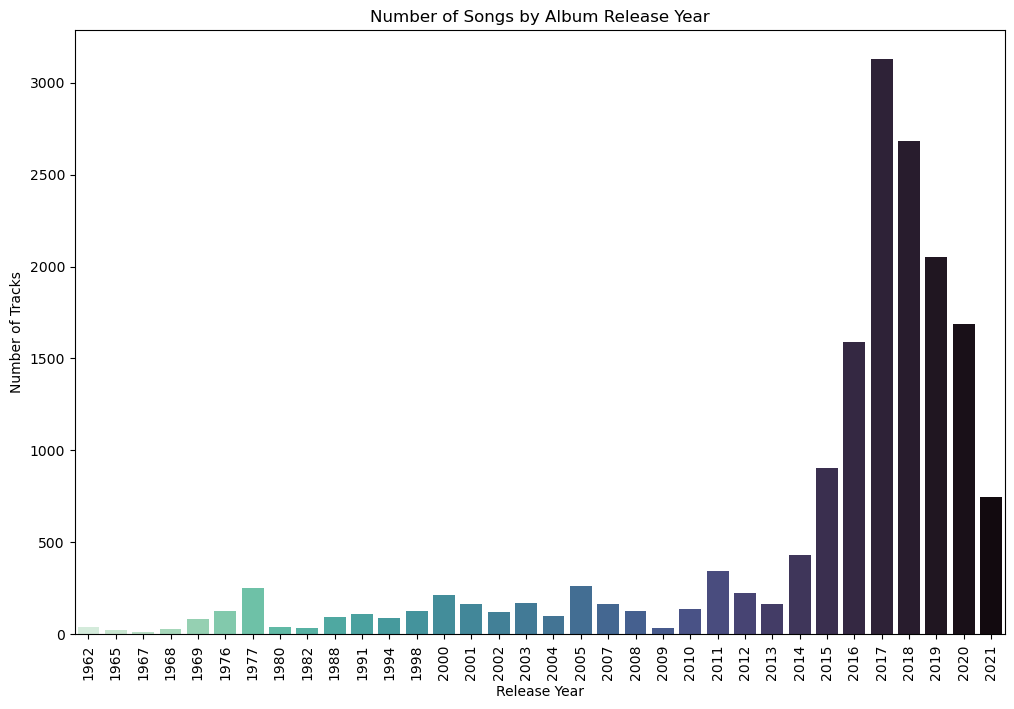

<Figure size 1200x800 with 0 Axes>

In [58]:
sns.barplot(data=release_year, x='year', y='track_name', palette='mako_r')
plt.xticks(rotation=90)
plt.title('Number of Songs by Album Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Tracks')
plt.show()
plt.savefig('../viz/pyplots/TracksPerReleaseYearBarChart.png')